<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Clasificaci%C3%B3n_de_vinos_tintos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Clasificador de vinos tintos, según su calidad, a partir de 11 características dadas.***

***Jesús Roque Armas Martín - CEIABD***

**El problema:** Se aportan 11 atributos que, en palabras del propio autor, pueden estar correlacionados, por lo que tiene sentido aplicarles algún tipo se selección de características, previa al estudio en sí.

Se incluyen 3 ficheros:

1.- llamado **winequality.names**, que incluye la explicación del problema y los nombres de los atributos aportados.

2.- **winequality-red.csv** - 1.599 registros de vinos tintos clasificados con una única columna de salida, que representa la calidad del vino, evaluada por expertos, y que va del 0 (muy malo) al 10 (excelente).

3.- **winequality-white.csv** - 4.898 registros clasificados de manera análoga para vinos blancos.

[URL de GitHub](https://github.com/roquearmas/IABD_DATA/blob/main/Clasificaci%C3%B3n_de_vinos_tintos.ipynb)


Importo las librerías necesarias

In [18]:
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.externals
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

import joblib

from sklearn.utils.multiclass import unique_labels
import xgboost as xgb
import random
import warnings
from google.colab import files



warnings.filterwarnings('ignore')

Cargamos el fichero del sistema de archivos local


In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving winequality-red.csv to winequality-red.csv
User uploaded file "winequality-red.csv" with length 84199 bytes


Leo el fichero csv y muestro los primeros registros del dataset


In [4]:
df_vinos = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),sep=';', header=0)
df_vinos.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Descripción estadística del dataset. Se observa que la calidad máxima es 8 y la mínima es 3.

In [4]:
df_vinos.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


Visualizar como están distribuidas las  calidades


Text(0.5, 1.0, 'Cantidad de vinos por calidad')

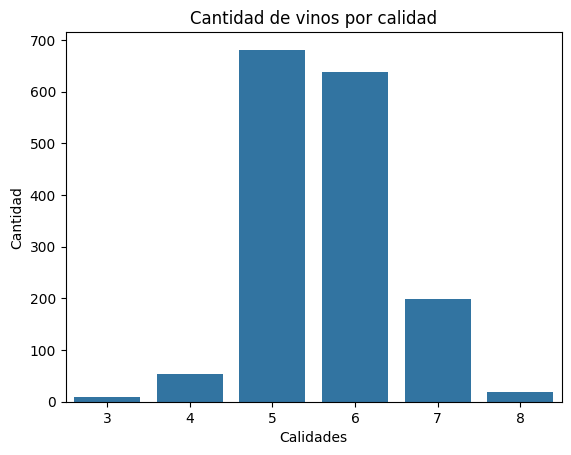

In [5]:
sns.countplot(x='quality',data=df_vinos)
plt.xlabel('Calidades')
plt.ylabel('Cantidad')
plt.title ('Cantidad de vinos por calidad')

Saco la matriz de correlación, para determinar las características más relevantes

In [6]:
df_vinos.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


Buscamos las posibles correlaciones con mapa de calor
- redondeo a dos decimales, para que la representación sea interpretable

- RdYlGn - Colores del mapa de calor (Rojo(Rd) - Amarillo(Yl) - Verde(Gn)

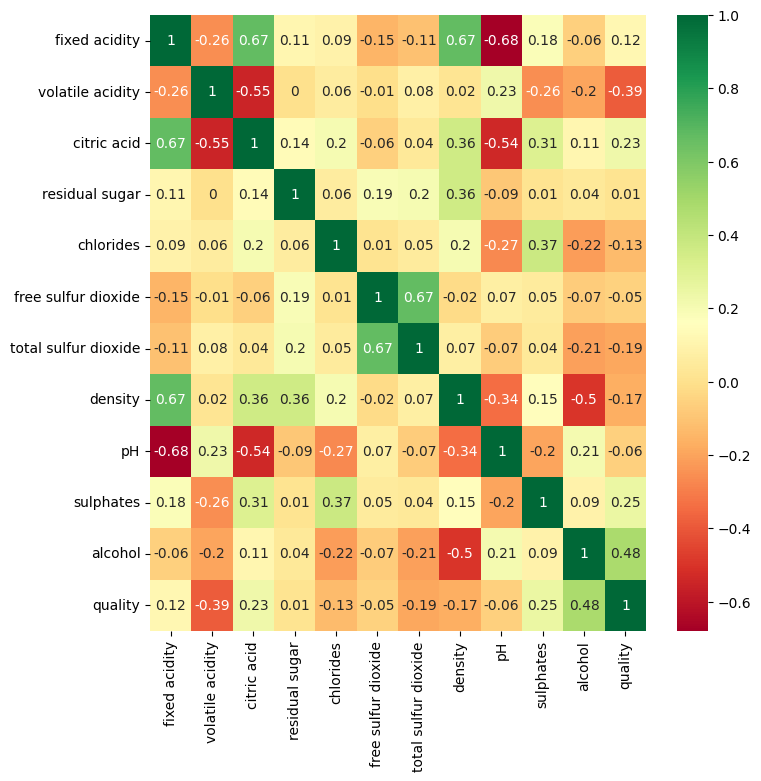

In [7]:
sns.heatmap(df_vinos.corr().round(2),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(8,8) # tamaño de la visualización
plt.show()


**Matriz de dispersión(Gráficos de dispersión)**

Tampoco se observa ninguna correlación entre los diferentes atributos


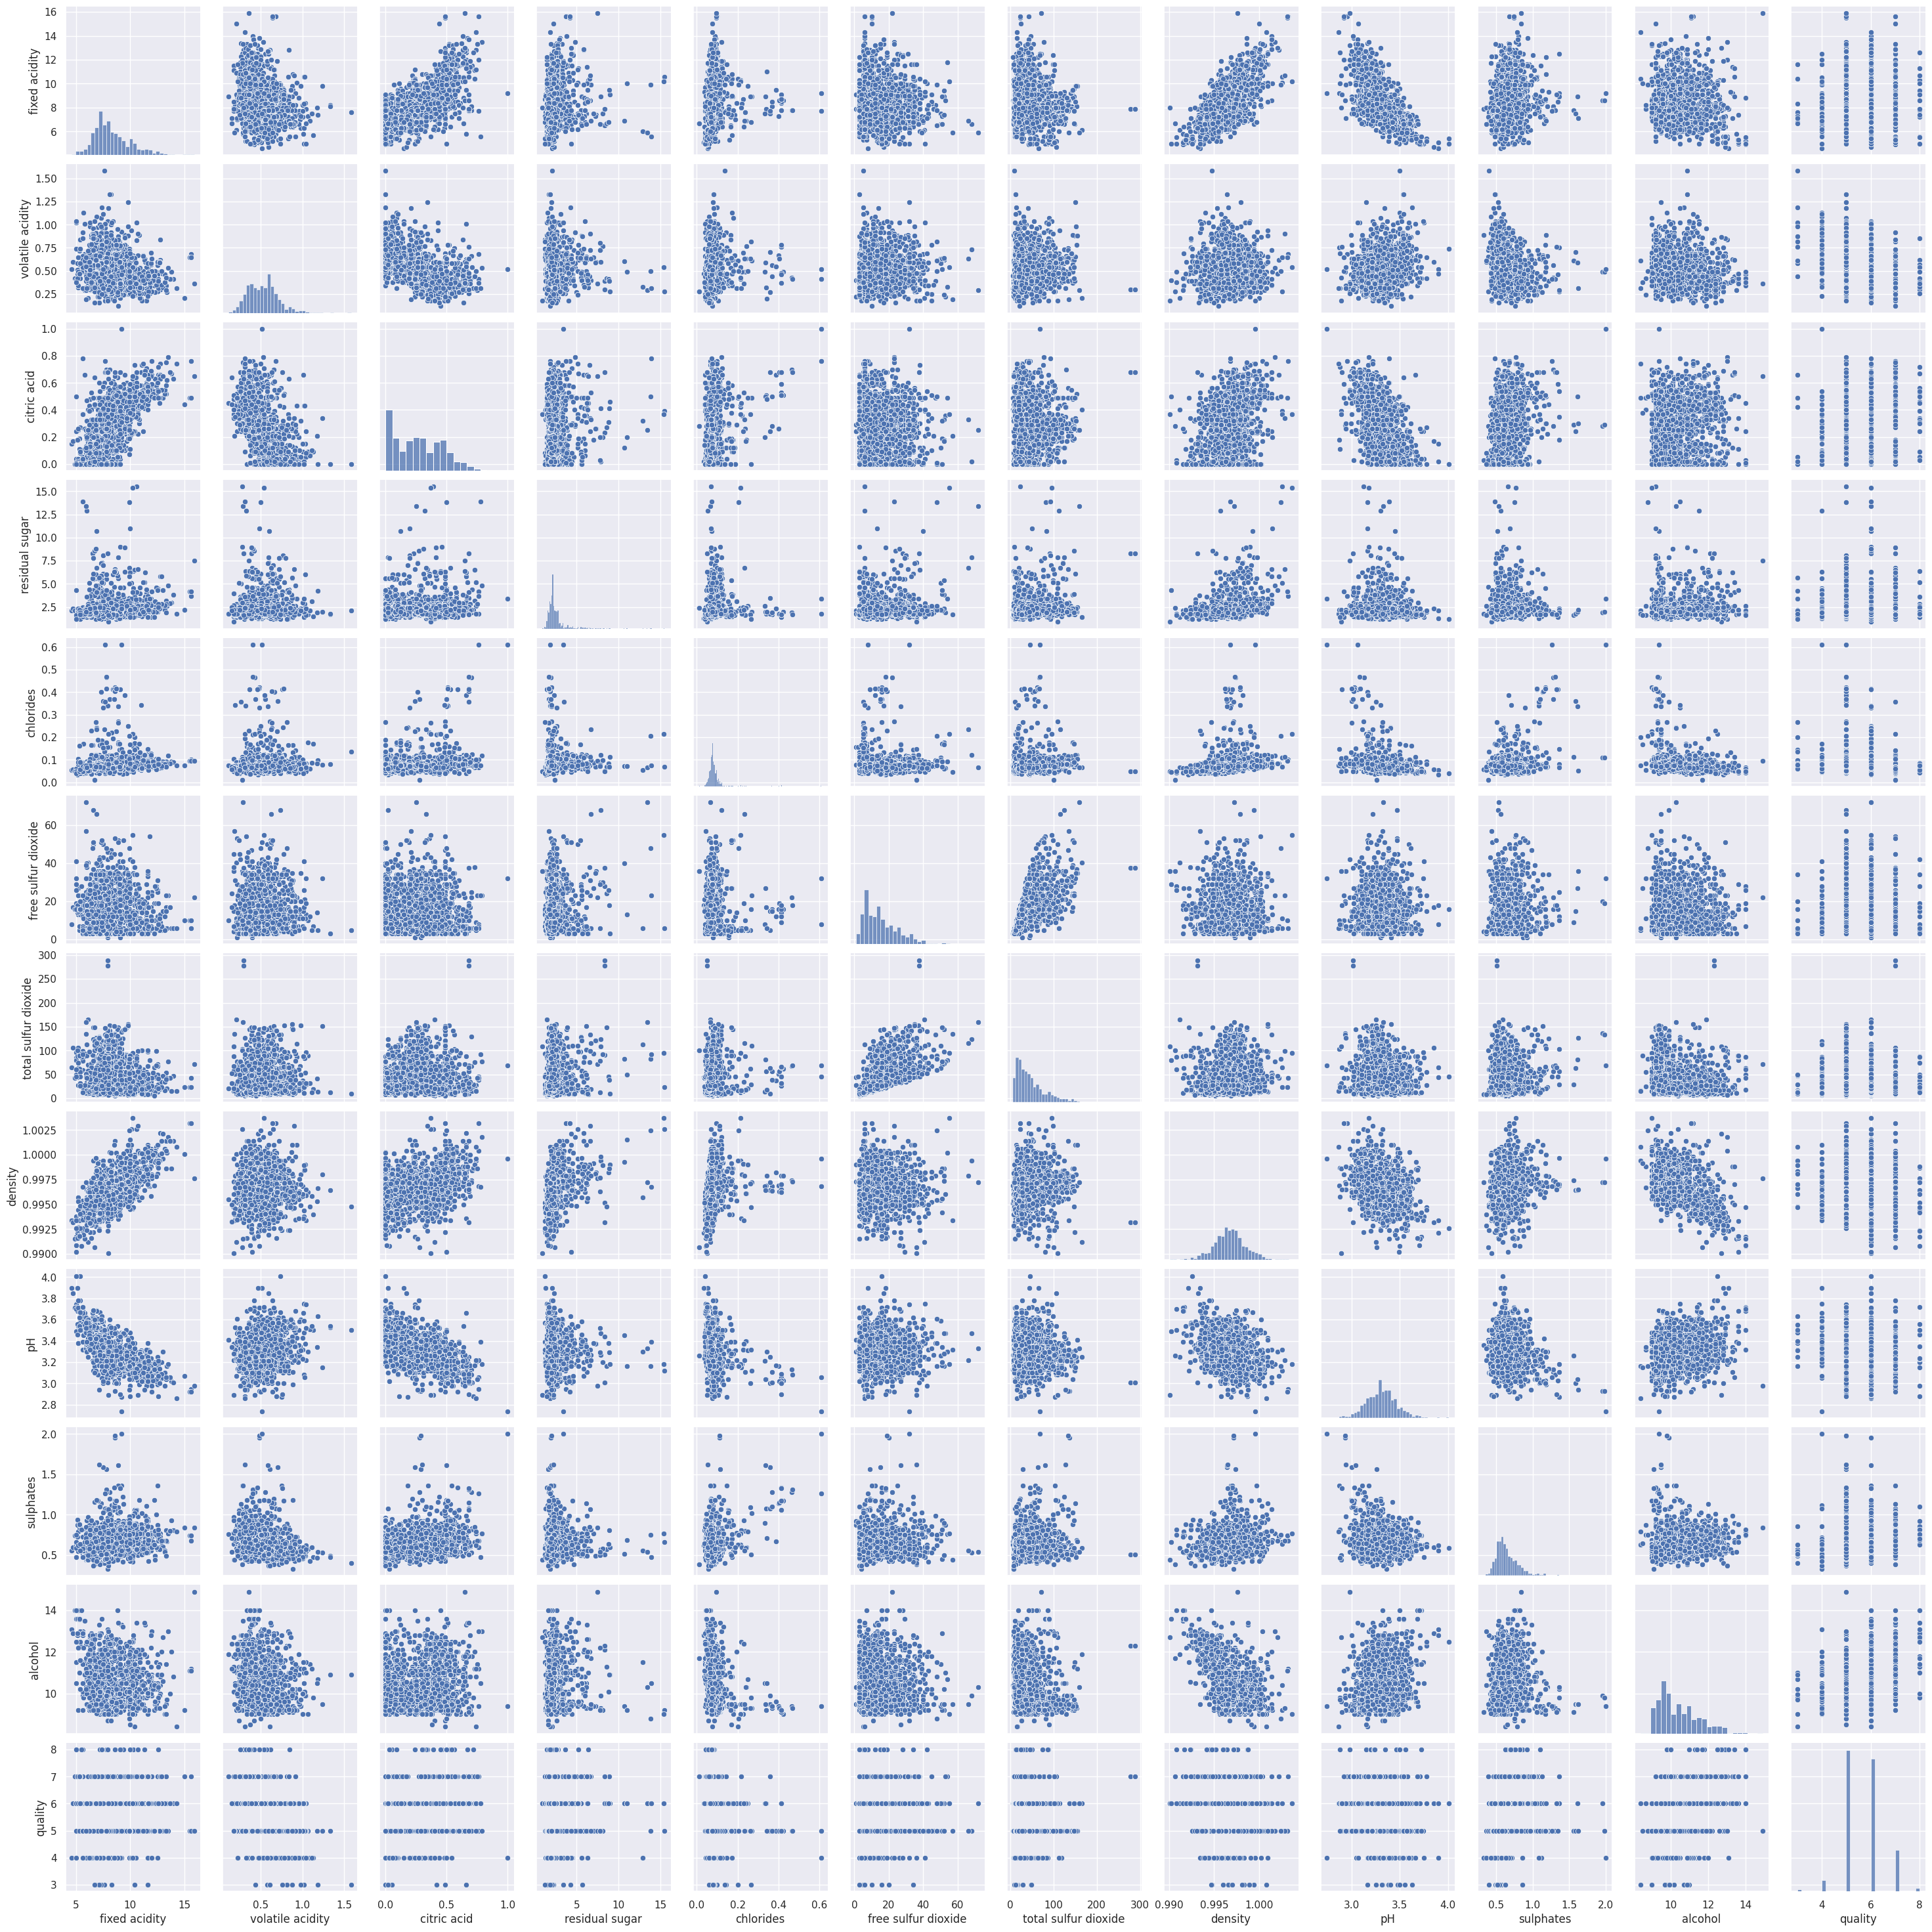

In [ ]:
sns.set()
sns.pairplot(df_vinos, size = 2.5)
plt.show();

Utilizo *selectKbest*, para intentar diferenciar las características más relevantes, dde las que no lo son.
El método ***score*** aporta la puntuación que toma *selectkbest* para determinar cuáles son las características más relevantes. A mayor puntuación, la característica está más relacionada con la variable objetivo (y).

Se calcula como la diferencia entre la puntuación de la característica y la puntuación promedio de todas las demás características.

Hay cuatro características que superan el 20% de puntuación. Por lo que me quedo con esas.

In [9]:
selector = SelectKBest(f_classif, k=11) # En K le indicamos el número de características que queremos seleccionar
x_carac_seleccionadas = selector.fit(df_vinos.iloc[:,:-1],df_vinos[df_vinos.columns[-1]])

# Aquí saco la puntuación que han obtenido las diferentes características, según SelectKBest
scores = selector.scores_
print(scores)
# Muestra las características seleccionadas
X_char_selected = selector.fit(df_vinos.iloc[:,:-1], df_vinos[df_vinos.columns[-1]])
# En este ejemplo no excluye ninguna característica al no haber correlación, cuando k=3
char_selected = X_char_selected.get_feature_names_out(None)
char_selected

[  6.28308116  60.91399283  19.69066447   1.05337358   6.03563859
   4.7542331   25.47850952  13.3963569    4.3417643   22.27337609
 115.85479747]


array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype=object)

Nos desembarazamos de las demás columnas

In [5]:
X_train = df_vinos.drop(['fixed acidity','citric acid', 'residual sugar',
                          'chlorides', 'free sulfur dioxide','pH','density'], axis=1)

X_train

,volatile acidity,total sulfur dioxide,sulphates,alcohol,quality
0,0.700,34.0,0.56,9.4,5
1,0.880,67.0,0.68,9.8,5
2,0.760,54.0,0.65,9.8,5
3,0.280,60.0,0.58,9.8,6
4,0.700,34.0,0.56,9.4,5
...,...,...,...,...,...
1594,0.600,44.0,0.58,10.5,5
1595,0.550,51.0,0.76,11.2,6
1596,0.510,40.0,0.75,11.0,6
1597,0.645,44.0,0.71,10.2,5


Separo las características del objetivo del estudio, la calidad del vino

In [6]:
# y_vinos = df_vinos['quality']
y_vinos = X_train.drop(['volatile acidity','total sulfur dioxide','sulphates','alcohol'],axis=1)
X_vinos = X_train.drop(['quality'], axis=1)


print(X_vinos,y_vinos)

      volatile acidity  total sulfur dioxide  sulphates  alcohol
0                0.700                  34.0       0.56      9.4
1                0.880                  67.0       0.68      9.8
2                0.760                  54.0       0.65      9.8
3                0.280                  60.0       0.58      9.8
4                0.700                  34.0       0.56      9.4
...                ...                   ...        ...      ...
1594             0.600                  44.0       0.58     10.5
1595             0.550                  51.0       0.76     11.2
1596             0.510                  40.0       0.75     11.0
1597             0.645                  44.0       0.71     10.2
1598             0.310                  42.0       0.66     11.0

[1599 rows x 4 columns]       quality
0           5
1           5
2           5
3           6
4           5
...       ...
1594        5
1595        6
1596        6
1597        5
1598        6

[1599 rows x 1 columns]


Escalo las características, antes de comenzar el estudio. Min Max Scales normalizará todos los valores entre 0 y 1

In [7]:
scaler= MinMaxScaler()
X_vinos = scaler.fit_transform(X_vinos)
X_vinos

array([[0.39726027, 0.09893993, 0.13772455, 0.15384615],
       [0.52054795, 0.2155477 , 0.20958084, 0.21538462],
       [0.43835616, 0.16961131, 0.19161677, 0.21538462],
       ...,
       [0.26712329, 0.12014134, 0.25149701, 0.4       ],
       [0.35958904, 0.13427562, 0.22754491, 0.27692308],
       [0.13013699, 0.12720848, 0.19760479, 0.4       ]])

Aplico Cross-Validation

In [8]:
def cv_modelo (modelo,s):
  cv = StratifiedKFold(n_splits=s, shuffle = True)
  cv_accu=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_vinos= np.array(X_vinos)
  y_train_vinos= np.array(y_vinos)
  for cv_train, cv_test in cv.split(X_train_vinos, y_train_vinos):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    # cv_train_x = X_train_vinos.iloc[cv_train]
    cv_train_x = X_train_vinos[cv_train]
    # cv_train_y = y_train_vinos.iloc[cv_train]
    cv_train_y = y_train_vinos[cv_train]
    #     cv_train_y= cv_train_y.apply(lambda x: x - 3)
    cv_train_y -=3 # para que el modelo GradientBoostingClassifier pueda trabajar con los datos de y
    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    y_test=y_vinos.iloc[cv_test].values
    y_test -=3
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_vinos[cv_test])
    accu= accuracy_score(y_test,y_pred)
    cv_accu.append(accu)

  # Calculo la precisión media y la devuelvo
  accu_media=sum(cv_accu)/len(cv_accu)
  return accu_media

Método para opitimizar el número de splits en el que se consigue una precisión máxima

In [20]:
def calcular_splits(modelo):
  accu_max=0.1
  accu=0.1
  split_dec=0
  for i in range(2,100,5):
    accu=cv_modelo (modelo,i)
    if accu>accu_max:
        accu_max=accu
        split_dec=i
  print ("Modelo %s Accuracy máxima: = %.4f para %d splits" %  (modelo,accu_max,split_dec ))

Voy entrenando los modeos con distinto número de splits, para obtener el mejor resultado

In [29]:
%%time
# DecisionTreeClassifier
calcular_splits(DecisionTreeClassifier())

# RandomForestClassifier
calcular_splits(RandomForestClassifier())

# GradientBoostingClassifier
calcular_splits(GradientBoostingClassifier())

# xgb.XGBClassifier
calcular_splits(xgb.XGBClassifier(n_estimators=100))

Modelo DecisionTreeClassifier() Accuracy máxima: = 0.6494 para 87 splits
Modelo RandomForestClassifier() Accuracy máxima: = 0.7105 para 37 splits
Modelo GradientBoostingClassifier() Accuracy máxima: = 0.6354 para 27 splits
Modelo XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) Accu

In [21]:
# AdaBoostClassifier
calcular_splits(AdaBoostClassifier())

# GradientBoostingClassifier
calcular_splits(BaggingClassifier())

Modelo AdaBoostClassifier() Accuracy máxima: = 0.5429 para 7 splits
Modelo BaggingClassifier() Accuracy máxima: = 0.6974 para 57 splits


Entreno el modelo con CrossValidation, para RandomForest , que es el que devuelve más precisión

In [30]:
accu_max=0.1
accu=0.1
split_dec=0
for i in range(33,41):
  accu=cv_modelo (RandomForestClassifier(),i)
  if accu>accu_max:
      accu_max=accu
      split_dec=i
print ("Modelo RandomForestClassifier Accuracy máxima: = %.4f para %d splits" %  (accu_max,split_dec ))

Modelo RandomForestClassifier Accuracy máxima: = 0.7128 para 35 splits


Busco el número óptimo de árboles (estimators). Aplicamos el modelo y número de splits obtenidos anteriormente RandomForestClassifier y 35 splits.


In [9]:
def Optimiza (criterio, estimators):
  accu_max=0.1
  accu=0.1
  # Con el parámetro n_estimator se indica el número de árboles en el bosque
  # el parámetro criterion es el criterio que se va a utilizar para medir la calidad de una división
  modelo =  RandomForestClassifier(n_estimators= estimators, criterion=criterio, random_state=0)
  cv = StratifiedKFold(n_splits=35, shuffle = True)
  cv_accu=[]
  # como el StratifiedKFold utiliza arrays de numpy, hay que convertir nuestros orígenes de datos
  X_train_vinos= np.array(X_vinos)
  y_train_vinos= np.array(y_vinos)
  for cv_train, cv_test in cv.split(X_train_vinos, y_train_vinos):
    # Sacamos la información de X y de Y, según las medidas dadas por la separación Kfold
    # cv_train_x = X_train_vinos.iloc[cv_train]
    cv_train_x = X_train_vinos[cv_train]
    # cv_train_y = y_train_vinos.iloc[cv_train]
    cv_train_y = y_train_vinos[cv_train]
    #     cv_train_y= cv_train_y.apply(lambda x: x - 3)
    cv_train_y -=3 # para que el modelo GradientBoostingClassifier pueda trabajar con los datos de y
    # vamos entrenando los modelos
    modelo.fit(cv_train_x, cv_train_y)
    y_test=y_vinos.iloc[cv_test].values
    y_test -=3
    #guardo el predict de cada modelo
    y_pred = modelo.predict(X_vinos[cv_test])
    accu= accuracy_score(y_test,y_pred)
    cv_accu.append(accu)

  # Calculo la precisión media y la devuelvo
  accu_media=sum(cv_accu)/len(cv_accu)
  return accu_media

Busco el mejor criterio y número óptimo de estimators - Gini - 18 estimators 70.55 % Accuracy

In [35]:
accu_max=0.1
accu=0.1
arboles=0
for i in range(1,20):
  accu=Optimiza('gini',i)
  if accu>accu_max:
      accu_max=accu
      arboles=i
print ("Modelo Gini Accuracy máxima: = %.4f para %d estimators" %  (accu_max,arboles ))


Modelo Gini Accuracy máxima: = 0.7055 para 18 estimators


Entropy - 16 estimators 69.31% Accuracy

In [36]:
accu_max=0.1
accu=0.1
arboles=0
for i in range(1,20):
  accu=Optimiza('entropy',i)
  if accu>accu_max:
      accu_max=accu
      arboles=i
print ("Modelo Entropy Accuracy máxima: = %.4f para %d estimators" %  (accu_max,arboles ))

Modelo Entropy Accuracy máxima: = 0.6931 para 16 estimators


Separo los conjuntos de entrenamiento, validación y test (60% - 20% - 20%) Stratify yes, para que balancee las y, en los distintos conjuntos


In [10]:
X_train, X_resto, y_train, y_resto = train_test_split(X_vinos, y_vinos, test_size=0.4, random_state=42, stratify=y_vinos)

# Dividir el resto en validación y prueba (50% cada uno)
X_val, X_test, y_val, y_test = train_test_split(X_resto, y_resto, test_size=0.5, random_state=42, stratify=y_resto)


Entreno el modelo elegido Random Forest



In [11]:
# Crear el modelo RandomForestClassifier con criterio Gini y 18 estimadores
modelo_rf_gini = RandomForestClassifier(n_estimators=18, criterion='gini', random_state=42)
modelo_rf_gini.fit(X_vinos, y_vinos)

# Realizar predicciones en el conjunto de prueba
y_pred_gini = modelo_rf_gini.predict(X_val)

exactitud_validacion = accuracy_score(y_val, y_pred_gini)
print(f"Precisión en el conjunto de validación: {exactitud_validacion:.2f}")

informe_clasificacion = classification_report(y_val, y_pred_gini)
print("Informe de clasificación en el conjunto de validación:\n", informe_clasificacion)

Precisión en el conjunto de validación: 0.99
Informe de clasificación en el conjunto de validación:
               precision    recall  f1-score   support

           3       1.00      0.50      0.67         2
           4       1.00      0.90      0.95        10
           5       0.99      1.00      0.99       137
           6       0.98      0.99      0.99       127
           7       1.00      0.97      0.99        40
           8       1.00      1.00      1.00         4

    accuracy                           0.99       320
   macro avg       0.99      0.89      0.93       320
weighted avg       0.99      0.99      0.99       320



Confusion matrix, without normalization
[[  9   0   1   0   0   0]
 [  0  52   0   1   0   0]
 [  0   0 680   1   0   0]
 [  0   0   2 636   0   0]
 [  0   0   0   4 195   0]
 [  0   0   0   1   0  17]]
Normalized confusion matrix
[[0.9        0.         0.1        0.         0.         0.        ]
 [0.         0.98113208 0.         0.01886792 0.         0.        ]
 [0.         0.         0.99853157 0.00146843 0.         0.        ]
 [0.         0.         0.0031348  0.9968652  0.         0.        ]
 [0.         0.         0.         0.0201005  0.9798995  0.        ]
 [0.         0.         0.         0.05555556 0.         0.94444444]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

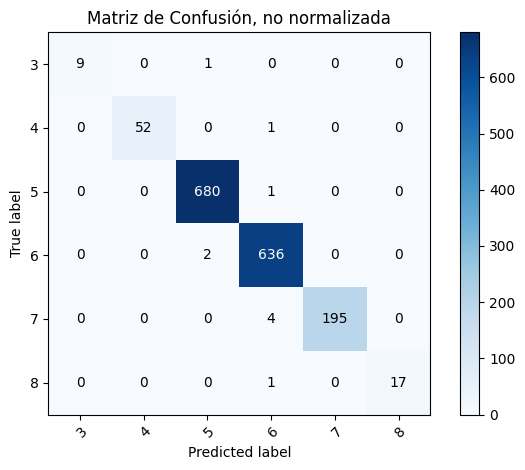

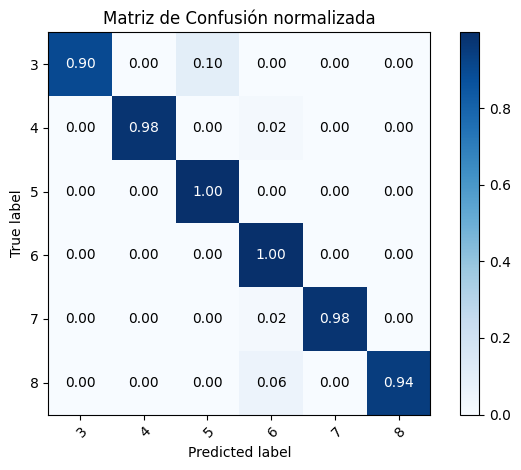

In [14]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo_rf_gini.predict(X_vinos)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_vinos, y_pred)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=False)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=True)

Función para dibujar la matriz de confusión

In [13]:
# y_true : dataframe -> Los valores de las clases que son ciertos (test)
# y_pred : ndarray   -> Los valores calculados de las clases después de realizar la predicción
# class  : ndarray   -> Los nombres de las clases/valores objetivos

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          titleSup=None):
    if not title:
        if normalize:
            title = 'Matriz de Confusión normalizada'
        else:
            title = 'Matriz de Confusión, no normalizada'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.suptitle(titleSup, fontsize=16, y=1, ha='center')
    return ax

Exporto el modelo a un fichero

In [15]:
# Para exportar el modelo a un fichero

joblib.dump(modelo_rf_gini,'ClasificacionVinosTintosRandomForest.pkl')

['ClasificacionVinosTintosRandomForest.pkl']

Importo el modelo pre entrenado.


In [16]:
modelo_cargado=joblib.load('ClasificacionVinosTintosRandomForest.pkl')

Aplico el modelo sobre los datos de test

Confusion matrix, without normalization
[[  9   0   1   0   0   0]
 [  0  52   0   1   0   0]
 [  0   0 680   1   0   0]
 [  0   0   2 636   0   0]
 [  0   0   0   4 195   0]
 [  0   0   0   1   0  17]]
Normalized confusion matrix
[[0.9        0.         0.1        0.         0.         0.        ]
 [0.         0.98113208 0.         0.01886792 0.         0.        ]
 [0.         0.         0.99853157 0.00146843 0.         0.        ]
 [0.         0.         0.0031348  0.9968652  0.         0.        ]
 [0.         0.         0.         0.0201005  0.9798995  0.        ]
 [0.         0.         0.         0.05555556 0.         0.94444444]]


<Axes: title={'center': 'Matriz de Confusión normalizada'}, xlabel='Predicted label', ylabel='True label'>

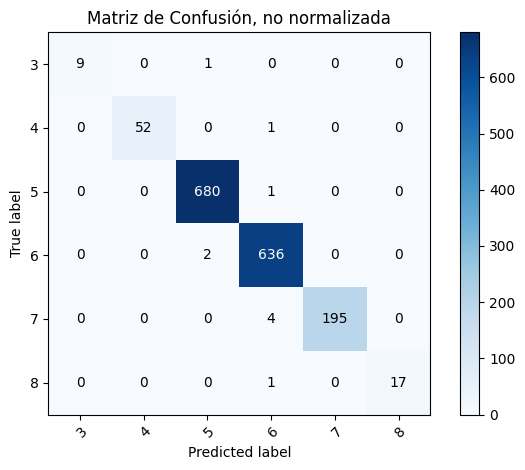

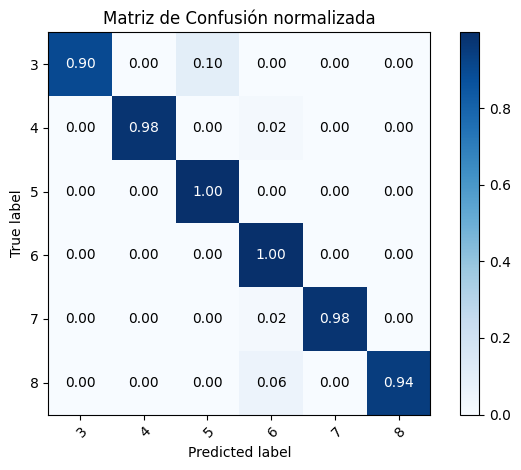

In [17]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo_cargado.predict(X_vinos)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_vinos, y_pred)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=False)
plot_confusion_matrix(y_vinos, y_pred,classes= np.array(['0',',1','2','3','4','5','6','7','8','9','10']) , normalize=True)